<a href="https://colab.research.google.com/github/patriciamedyna/Classifier_page/blob/main/LSTM_Classifier_with_Tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')

In [3]:
# obtem a classe (numero de paginas) do arquivo
def get_target(filepath):
    fname = filepath.split('/')[-1]
    if '_' in fname:
        return 1
        
    return 0

In [4]:
# obter todo o conteudo de texto do arquivo
def extract_content(filepath):
    data = []
    with open(filepath, 'r') as fp:
        data = fp.readlines()
    
    return data

In [5]:
def clean_text(text):
    text = str(text).lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    
    return text

In [10]:
pathsrc = '/content/drive/MyDrive/Colab Notebooks/Tobacco_LSTM/'
files = glob.glob(pathsrc + 'txt/*.txt')
len(files)

1290

In [12]:
texts = []
target = []
for i, fp in enumerate(files):
  target.append(get_target(fp))
  texts.append(extract_content(fp))
  #print(f'{i} process.')

In [13]:
df = pd.DataFrame({'texts': texts, 'pages': target})
df.head()

,texts,pages
0,[xxQ00_00 xxbob JUL 14 14:48 FR CALIFORNIA SPE...,0
1,"[xxQ00_02 xxbob ®\n, xxeob xxQ00_01\n, xxQ00_0...",1
2,"[xxQ04_02 xxbob BAILOWOLITY\n, xxbcet |\n, xxe...",1
3,"[xxQ00_00 xxbob THE\n, AMERICAN\n, TOBACCO\n, ...",1
4,"[xxQ00_01 xxbob xxbcet Tse For Inc.\n, xxecet ...",0


In [15]:
pd.set_option('display.max_colwidth', None)
df.head()

,texts,pages
0,"[xxQ00_00 xxbob JUL 14 14:48 FR CALIFORNIA SPEEDURY 429 5998 TO 919176631462\n, xxeob xxQ01_00\n, xxQ01_00 xxbob july 7, 2900\n, xxeob xxQ01_00\n, xxQ01_00 xxbob Philip Morris, USA\n, -120 Park Avenue\n, xxeob xxQ02_01\n, xxQ01_00 xxbob New York, NY 10017-5592\n, Dear ina,\n, xxeob xxQ03_03\n, xxQ02_00 xxbob xxbcet Thank far your time today with our several conversations over the telephone.\n, xxecet you regarding Marlboro Racing Experience and\n, writing the agreement we that we agreement that for the of the\n, SportService. tis my understanding are all in -\n, Racing Experience which is September 21* through October 6"", Mariboro will.continue\n, all food and beverage directly from Califomia Sportservice. Beginning with the\n, to purchase November 6* and continue on various days\n, Marlboro Racing Experience scheduled to start on service\n, through December 15"", Marlboro will be able to conduct their own food and beverage\n, the involvement of California SportService. in consideration of this privilege Mariboro\n, without of $2,500 day for each event food\n, to pay California SportService a self-catering fee per\n, agrees down days will not require any self-catering fee. Marlboro will be\n, service day. Set up and tear fees.\n, invoiced by California SportService on a monthly basis for all event day self-catering\n, This agreement will remain in effect for the balance of 2000 and ail scheduled Mariboro\n, Racing Experience event food service days in 2001. The self-catering fee will be reviewed and\n, modified by mutual agreement for 2002 and beyond, A formal will be\n, potentially future this is intended only to our verbal\n, provided by our legal department in the near as\n, xxbcet agreement. reflects understanding please indicate by signing below\n, xxecet If this document accurately your spirit of\n, xxbcet and retuming a copy to my attention or sending a confirming letter. | appreciate your\n, xxecet cooperation and hope this provides a positive solution for all involved.\n, xxeob xxQ04_00\n, xxQ04_00 xxbob Sincerely,\n, xxeob xxQ05_02\n, xxQ04_00 xxbob Ina Broem\n, xxbcet Greg Penske | : Mortis, USA\n, xxecet ce:\n, Brian Geye\n, xxeob xxQ05_01\n, xxQ05_00 xxbob xxbcet Otis Creer\n, xxecet xxeob xxQ05_03\n, xxQ05_00 xxbob SPEEDWAY CHERRY FONTANA, UGA (900) / FAX (900)\n, TOTAL\n, xxeob xxQ05_03\n, xxQ04_03 xxbob 0602970802\n, xxeob xxQ05_03\n]",0
1,"[xxQ00_02 xxbob ®\n, xxeob xxQ00_01\n, xxQ00_01 xxbob Phase\n, xxeob xxQ00_03\n, xxQ00_00 xxbob Now smoke two packs of the cigarette coded and circle\n, Just did . a Number for each pair of phrases\n, as you before.\n, xxeob xxQ00_00\n, xxQ00_00 xxbob CIGARETTES CODED\n, xxeob xxQ02_03\n, xxQ00_00 xxbob xxbcet Too much menthol taste. | 3 | 2 |3 7] enough menthol taste,\n, xxecet Burns too fast, 2-13 14 15 16 Does not burn too fast,\n, 4\n, xxbcet Is dry tasting. | 2 [4 {5 [6 [7 } Is not dry tasting,\n, xxecet xxbcet Does not have a good taste. | 1 15 6 | | Has a good taste,\n, xxecet xxbcet Is harsh tasting. 13 | 1s not harsh tasting,\n, xxecet Has a bitter taste. [4 7 Does not have bitter\n, a taste.\n, xxeob xxQ01_03\n, xxQ01_02 xxbob Has draw,\n, xxeob xxQ02_03\n, xxQ02_00 xxbob Is not satisfying. 4 6 Is satisfying.\n, Leaves a bad aftertaste Leaves good aftertaste\n, in 2 a\n, xxbcet my mouth. | 1 | 2 in my mouth,\n, xxecet xxbcet Too mich cooling. | 2 4 Too little cooling.\n, xxecet xxeob xxQ02_03\n, xxQ02_00 xxbob I dislike extremely. 1/2 [4 1 like extremely,\n, xxeob xxQ03_01\n, xxQ02_01 xxbob Phase LII\n, xxeob xxQ03_03\n, xxQ03_00 xxbob “ow that you have completed Phases 1 and smoke of the remaining\n, codes and the following: some cigarettes of both\n, answer\n, xxeob xxQ03_03\n, xxQ03_00 xxbob “Which has the better menthol taste? J 0 Preference\n, Which cigarette is more satisfying? J Preference\n, xxbcet Which cigarette is the milder smoke? [| J Preference\n, xxecet xxeob xxQ04_03\n, xxQ03_00 xxbob Which cigarette has better amount of J Preferenc

In [16]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

In [17]:
# definir minhas features - contexto
X_train = df['texts'].apply(lambda p: clean_text(p))

phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
'max phrase len: {0}'.format(max_phrase_len)

'max phrase len: 1243'

In [ ]:
pd.set_option('display.max_colwidth', None)
df.head()

In [20]:
# target
y_train = df['pages']

# words to numbers
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)

In [21]:
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [26]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, 
                         output_dim = 256, 
                         input_length = max_phrase_len))

model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(2, activation = 'softmax'))

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [27]:
history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 10,
    batch_size = 128,
)

model_lstm.save("lstm_model.h5")

Epoch 1/10
8/8 [==============================] - 58s 7s/step - loss: 0.6792 - accuracy: 0.6110 - val_loss: 0.6593 - val_accuracy: 0.6154
Epoch 2/10
8/8 [==============================] - 52s 7s/step - loss: 0.6566 - accuracy: 0.6185 - val_loss: 0.6509 - val_accuracy: 0.6154
Epoch 3/10
8/8 [==============================] - 53s 7s/step - loss: 0.6340 - accuracy: 0.6185 - val_loss: 0.5791 - val_accuracy: 0.6250
Epoch 4/10
8/8 [==============================] - 53s 7s/step - loss: 0.5967 - accuracy: 0.7101 - val_loss: 0.5856 - val_accuracy: 0.6827
Epoch 5/10
8/8 [==============================] - 53s 7s/step - loss: 0.5072 - accuracy: 0.7737 - val_loss: 0.6649 - val_accuracy: 0.7212
Epoch 6/10
8/8 [==============================] - 52s 7s/step - loss: 0.4653 - accuracy: 0.7953 - val_loss: 0.4825 - val_accuracy: 0.7981
Epoch 7/10
8/8 [==============================] - 53s 7s/step - loss: 0.3783 - accuracy: 0.8524 - val_loss: 0.4056 - val_accuracy: 0.8077
Epoch 8/10
8/8 [==================

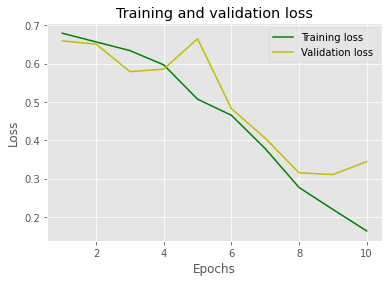

In [28]:

plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

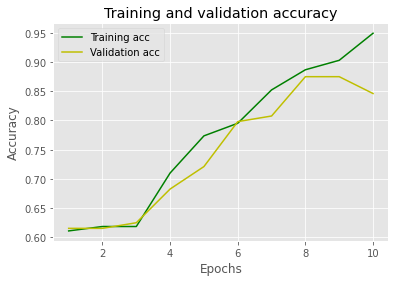

In [29]:

plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [30]:
y_pred = model_lstm.predict(X_test)

Accuracy: 0.7984496124031008
F1_score: 0.8479532163742689


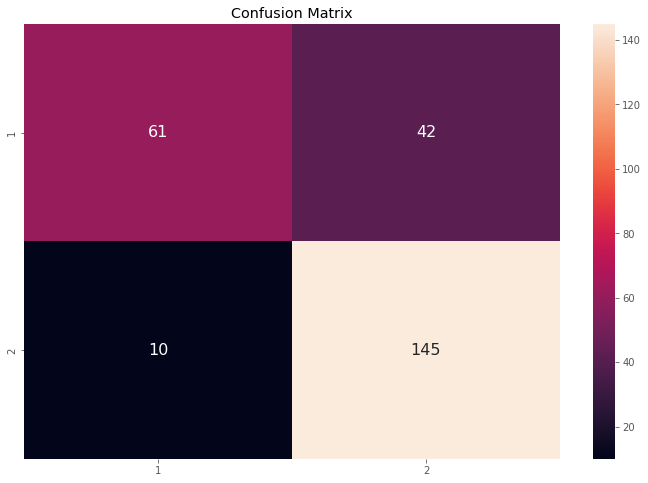

In [37]:
F1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

print("Accuracy: {}".format(acc))
print("F1_score: {}".format(F1))
df_cm = pd.DataFrame(cm, [1,2], [1,2])
fig, axs = plt.subplots(1,1, figsize=(12,8))
sns.heatmap(df_cm, annot=True, ax=axs, annot_kws={"size": 16}, fmt="d") 
axs.set_title('Confusion Matrix')
plt.show()

In [32]:
f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

0.8479532163742689